In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


loan = pd.read_csv('accepted_2007_to_2018Q4.csv')

return_number = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

def convert_date(d):
    try:
        return datetime.date(year=int(d[4:]), month=return_number[d[:3]], day=1)
    except:
        pass

loan['issue_d'] = loan['issue_d'].apply(convert_date)
loan['earliest_cr_line'] = loan['earliest_cr_line'].apply(convert_date)

loan = loan[loan.issue_d < datetime.date(2015,7,1)]
loan = loan[loan.issue_d >= datetime.date(2010,1,1)]

loan = loan[loan.term == ' 36 months']

loan['earliest_cr_line'] = loan.apply(lambda x: (x['issue_d'] - x['earliest_cr_line']).days, axis=1)

loan = loan[(loan.loan_status == 'Fully Paid') | (loan.loan_status == 'Charged Off')]

loan = loan[loan.annual_inc < 1000000]

loan['ln_annual_inc'] = np.log(loan.annual_inc)

loan = loan[loan.revol_util < 150]
loan['ln_revol_bal'] = np.log(loan.revol_bal+1)

loan['ln_earliest_cr_line'] = np.log(loan.earliest_cr_line)

loan['ln_open_acc'] = np.log(loan.open_acc)

loan.rename(columns = {'delinq_2yrs': 'num_delinq_2yrs'}, inplace=True)
loan['delinq_2yrs'] = (loan['num_delinq_2yrs'] >= 1)

loan.rename(columns = {'pub_rec': 'num_pub_rec'}, inplace=True)
loan['pub_rec'] = (loan['num_pub_rec'] >= 1)

loan.rename(columns = {'inq_last_6mths': 'num_inq_last_6mths'}, inplace=True)
loan['inq_last_6mths'] = (loan['num_inq_last_6mths'] >= 1)

loan['target'] = (loan['loan_status'] == 'Fully Paid')

In [3]:
col_list = ['loan_amnt', 'int_rate', 'ln_annual_inc', 'dti', 'fico_range_high', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'num_inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'ln_open_acc', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']


In [4]:
# We will use 2010-2013 to tune our models, and save data from 2014 and the first 
# 6 months of 2015 for walk-forward testing

train = loan[loan.issue_d < datetime.date(2014, 1, 1)]
test = loan[(loan.issue_d >= datetime.date(2014, 1, 1)) & (loan.issue_d < datetime.date(2015, 7, 1))]


In [5]:
loan.shape

(449486, 159)

In [6]:
train.shape

(166313, 159)

In [7]:
print('2010: {}'.format(sum([x.year == 2010 for x in train.issue_d])))
print('2011: {}'.format(sum([x.year == 2011 for x in train.issue_d])))
print('2012: {}'.format(sum([x.year == 2012 for x in train.issue_d])))
print('2013: {}'.format(sum([x.year == 2013 for x in train.issue_d])))

2010: 8445
2011: 14092
2012: 43423
2013: 100353


In [8]:
import statsmodels.api as sm

y = train['target']
X1 = train[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2 = pd.concat([X1, train.int_rate, pd.get_dummies(train.grade)], axis=1)
X3 = pd.concat([X1, train.int_rate, pd.get_dummies(train.sub_grade)], axis=1)
X1 = sm.add_constant(X1)


In [9]:
type(y)

pandas.core.series.Series

In [10]:
type(X1)

pandas.core.frame.DataFrame

In [11]:
X1.shape

(166313, 16)

In [12]:
import statsmodels.discrete as smd

logit = smd.discrete_model.Logit(y, X1.astype(float)).fit()
logit_me = logit.get_margeff()
logit_me.summary()

Optimization terminated successfully.
         Current function value: 0.359305
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                 target
Method:                          dydx
At:                           overall
=======================================================================================
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
loan_amnt           -2.459e-06   1.38e-07    -17.878      0.000   -2.73e-06   -2.19e-06
ln_annual_inc           0.0621      0.002     29.539      0.000       0.058       0.066
dti                    -0.0015      0.000    -11.829      0.000      -0.002      -0.001
fico_range_high         0.0012    3.8e-05     32.077      0.000       0.001       0.001
delinq_2yrs             0.0088      0.004      2.480      0.013       0.002       0.016
num_delinq_2yrs        -0.0017      0.002     -0.955      0.340      -0.005       0.002
ln_earliest_cr_line    -0.0023      0.002     -1.224      0.221      -0.006       0.001
inq_last_6mths         -0.0065      0.003     -2.528      0.011      -0.012      -0.001
num_inq_last_6mths     -0.0171      0.001    -14.271      0.000      -0.020      -0.015
ln_open_acc            -0.0215      0.003     -8.045      0.000      -0.027      -0.016
pub_rec                 0.0133      0.005      2.894      0.004       0.004       0.022
num_pub_rec          1.869e-05      0.003      0.006      0.995      -0.006       0.006
ln_revol_bal            0.0132      0.001     14.761      0.000       0.011       0.015
revol_util             -0.0004   4.85e-05     -9.023      0.000      -0.001      -0.000
total_acc               0.0009      0.000      7.896      0.000       0.001       0.001
=======================================================================================
"""

In [13]:
logit2 = smd.discrete_model.Logit(y, X2.astype(float)).fit()
logit2_me = logit2.get_margeff()
logit2_me.summary()

Optimization terminated successfully.
         Current function value: 0.356435
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                 target
Method:                          dydx
At:                           overall
=======================================================================================
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
loan_amnt           -1.867e-06   1.36e-07    -13.773      0.000   -2.13e-06    -1.6e-06
ln_annual_inc           0.0576      0.002     27.607      0.000       0.053       0.062
dti                    -0.0012      0.000     -9.397      0.000      -0.001      -0.001
fico_range_high         0.0005   4.56e-05     10.062      0.000       0.000       0.001
delinq_2yrs             0.0079      0.004      2.223      0.026       0.001       0.015
num_delinq_2yrs        -0.0009      0.002     -0.513      0.608      -0.004       0.003
ln_earliest_cr_line    -0.0037      0.002     -1.957      0.050      -0.007     6.2e-06
inq_last_6mths          0.0011      0.003      0.421      0.674      -0.004       0.006
num_inq_last_6mths     -0.0119      0.001     -9.868      0.000      -0.014      -0.010
ln_open_acc            -0.0206      0.003     -7.772      0.000      -0.026      -0.015
pub_rec                 0.0092      0.005      1.826      0.068      -0.001       0.019
num_pub_rec             0.0017      0.004      0.456      0.649      -0.006       0.009
ln_revol_bal            0.0087      0.001      9.408      0.000       0.007       0.010
revol_util             -0.0002   4.88e-05     -3.916      0.000      -0.000   -9.55e-05
total_acc               0.0007      0.000      6.056      0.000       0.000       0.001
int_rate               -0.0076      0.001    -10.963      0.000      -0.009      -0.006
A                      -0.5860      0.042    -14.012      0.000      -0.668      -0.504
B                      -0.5968      0.042    -14.371      0.000      -0.678      -0.515
C                      -0.6046      0.042    -14.421      0.000      -0.687      -0.522
D                      -0.6074      0.043    -14.236      0.000      -0.691      -0.524
E                      -0.5986      0.044    -13.729      0.000      -0.684      -0.513
F                      -0.5958      0.045    -13.262      0.000      -0.684      -0.508
G                      -0.6173      0.053    -11.675      0.000      -0.721      -0.514
=======================================================================================
"""

In [14]:
logit3 = smd.discrete_model.Logit(y, X3.astype(float)).fit()
logit3_me = logit3.get_margeff()
logit3_me.summary()

         Current function value: 0.356164
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                 target
Method:                          dydx
At:                           overall
=======================================================================================
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
loan_amnt           -1.786e-06   1.36e-07    -13.139      0.000   -2.05e-06   -1.52e-06
ln_annual_inc           0.0574      0.002     27.554      0.000       0.053       0.062
dti                    -0.0012      0.000     -9.379      0.000      -0.001      -0.001
fico_range_high         0.0004   4.68e-05      8.173      0.000       0.000       0.000
delinq_2yrs             0.0079      0.004      2.223      0.026       0.001       0.015
num_delinq_2yrs        -0.0010      0.002     -0.535      0.592      -0.004       0.003
ln_earliest_cr_line    -0.0046      0.002     -2.418      0.016      -0.008      -0.001
inq_last_6mths          0.0018      0.003      0.688      0.492      -0.003       0.007
num_inq_last_6mths     -0.0117      0.001     -9.677      0.000      -0.014      -0.009
ln_open_acc            -0.0215      0.003     -8.106      0.000      -0.027      -0.016
pub_rec                 0.0091      0.005      1.799      0.072      -0.001       0.019
num_pub_rec             0.0017      0.004      0.464      0.643      -0.006       0.009
ln_revol_bal            0.0082      0.001      8.902      0.000       0.006       0.010
revol_util             -0.0002   4.89e-05     -3.504      0.000      -0.000   -7.54e-05
total_acc               0.0007      0.000      6.117      0.000       0.000       0.001
int_rate               -0.0036      0.001     -3.128      0.002      -0.006      -0.001
A1                     -0.5055      0.044    -11.454      0.000      -0.592      -0.419
A2                     -0.5248      0.043    -12.122      0.000      -0.610      -0.440
A3                     -0.5403      0.043    -12.593      0.000      -0.624      -0.456
A4                     -0.5571      0.042    -13.125      0.000      -0.640      -0.474
A5                     -0.5650      0.042    -13.341      0.000      -0.648      -0.482
B1                     -0.5699      0.042    -13.453      0.000      -0.653      -0.487
B2                     -0.5714      0.042    -13.472      0.000      -0.655      -0.488
B3                     -0.5765      0.043    -13.561      0.000      -0.660      -0.493
B4                     -0.5831      0.043    -13.657      0.000      -0.667      -0.499
B5                     -0.5907      0.043    -13.777      0.000      -0.675      -0.507
C1                     -0.5924      0.043    -13.766      0.000      -0.677      -0.508
C2                     -0.5964      0.043    -13.772      0.000      -0.681      -0.512
C3                     -0.6077      0.044    -13.960      0.000      -0.693      -0.522
C4                     -0.6104      0.044    -13.957      0.000      -0.696      -0.525
C5                     -0.6041      0.044    -13.692      0.000      -0.691      -0.518
D1                     -0.6180      0.044    -13.930      0.000      -0.705      -0.531
D2                     -0.6159      0.045    -13.775      0.000      -0.704      -0.528
D3                     -0.6157      0.045    -13.676      0.000      -0.704      -0.527
D4                     -0.6231      0.045    -13.766      0.000      -0.712      -0.534
D5                     -0.6109      0.046    -13.356      0.000      -0.701      -0.521
E1                     -0.6147      0.046    -13.310      0.000      -0.705      -0.524
E2                     -0.6233      0.047    -13.361      0.000      -0.715      -0.532
E3                     -0.6136      0.047    -13.008      0.000      -0.706      -0.521
E4                     -0.6209      0.048    -12.993      0.000   

In [15]:
X1_test = test[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.grade)], axis=1)
X3_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.sub_grade)], axis=1)
X1_test = sm.add_constant(X1_test)
y_test = test['target']

test['pred'] = logit.predict(X1_test.astype(float))
test['pred2'] = logit2.predict(X2_test.astype(float))
test['pred3'] = logit3.predict(X3_test.astype(float))

id                      0
member_id          166313
loan_amnt               0
funded_amnt             0
funded_amnt_inv         0
                    ...  
ln_open_acc             0
delinq_2yrs             0
pub_rec                 0
inq_last_6mths          0
target                  0
Length: 159, dtype: int64


In [17]:
sum_stats = train.groupby(['grade'])[['int_rate', 'annual_inc', 'fico_range_high', 'dti', 'loan_amnt', 'target']].mean()
sum_stats_test = test.groupby(['grade'])[['int_rate', 'annual_inc', 'fico_range_high', 'dti', 'loan_amnt', 'target','pred', 'pred2', 'pred3']].mean()
comparison = pd.merge(sum_stats, sum_stats_test, on=['grade'])[['int_rate_x', 'target_x', 'int_rate_y', 'target_y', 'pred', 'pred2', 'pred3']]
comparison.rename(columns={'int_rate_x': 'int_rate_train',
                           'target_x': 'compliance_train',
                           'int_rate_y': 'int_rate_test',
                           'target_y': 'compliance_test'
                          }, inplace=True)
comparison

,int_rate_train,compliance_train,int_rate_test,compliance_test,pred,pred2,pred3
grade,,,,,,,
A,7.533552,0.943643,7.257456,0.944358,0.917446,0.942881,0.942637
B,11.784927,0.894520,10.776167,0.887245,0.878406,0.901482,0.897536
C,15.175030,0.842224,13.752072,0.820389,0.850389,0.856179,0.848309
D,18.259644,0.797595,16.856570,0.761690,0.830258,0.807749,0.798779
E,20.967960,0.774016,19.899155,0.709688,0.817479,0.774749,0.766657
F,23.139601,0.740024,24.083902,0.675883,0.806044,0.714623,0.713314
G,23.226515,0.727273,25.856337,0.641026,0.780693,0.615993,0.634662


In [18]:
test.groupby(['grade']).count()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_title,...,ln_revol_bal,ln_earliest_cr_line,ln_open_acc,delinq_2yrs,pub_rec,inq_last_6mths,target,pred,pred2,pred3
grade,,,,,,,,,,,,,,,,,,,,,
A,65921,0,65921,65921,65921,65921,65921,65921,65921,62830,...,65921,65921,65921,65921,65921,65921,65921,65921,65921,65921
B,89158,0,89158,89158,89158,89158,89158,89158,89158,83849,...,89158,89158,89158,89158,89158,89158,89158,89158,89158,89158
C,77668,0,77668,77668,77668,77668,77668,77668,77668,72331,...,77668,77668,77668,77668,77668,77668,77668,77668,77668,77668
D,35865,0,35865,35865,35865,35865,35865,35865,35865,32845,...,35865,35865,35865,35865,35865,35865,35865,35865,35865,35865
E,11684,0,11684,11684,11684,11684,11684,11684,11684,10592,...,11684,11684,11684,11684,11684,11684,11684,11684,11684,11684
F,2604,0,2604,2604,2604,2604,2604,2604,2604,2318,...,2604,2604,2604,2604,2604,2604,2604,2604,2604,2604
G,273,0,273,273,273,273,273,273,273,244,...,273,273,273,273,273,273,273,273,273,273


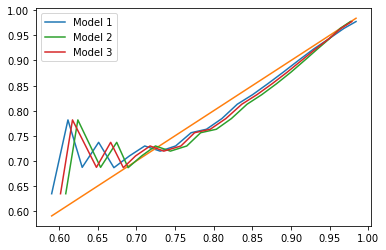

In [19]:
pred = []
act = []
pred2 = []
pred3 = []

for i in range(21):
    min = .58 + i*.02
    max = .58 + (i+1)*.02
    df = test[(test['pred'] >= min)&(test['pred'] < max)]
    pred_compliance = df['pred'].mean()
    act_compliance = df['target'].mean()
    pred.append(pred_compliance)
    pred2.append(df['pred2'].mean())
    pred3.append(df['pred3'].mean())
    act.append(act_compliance)
    #print('{} to {}:'.format(round(min,2), round(max,2)))
    #print('sample size: {}'.format(df.shape[0]))
    #print('predicted %: {}'.format(round(pred_compliance, 3)))
    #print('actual %:    {}'.format(round(act_compliance, 3)))
    #print('')
    
plt.plot(pred, act, label='Model 1')
plt.plot(pred, pred)
plt.plot(pred2, act, label='Model 2')
plt.plot(pred3, act, label='Model 3')
plt.legend()
plt.show()

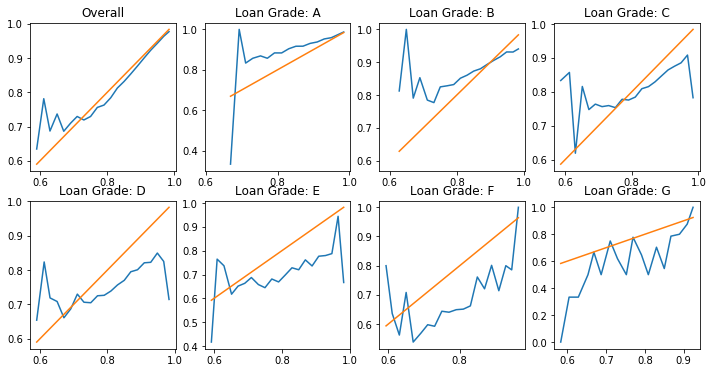

In [20]:
def graph_by_grade(predictions, grade, target):
    pred = []
    act = []
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    
    plt.figure(figsize=(12,6))
    plt.subplot(2,4,1)
    plt.title("Overall")
    
    for i in range(21):
        
        lb = .58 + i*.02
        ub = .58 + (i+1)*.02
        sub = ((predictions >= lb)&(predictions < ub))
        pred_compliance = predictions[sub].mean()
        act_compliance = target[sub].mean()
        pred.append(pred_compliance)
        act.append(act_compliance)

    plt.plot(pred, act)
    plt.plot(pred, pred)

    for letter in range(7):
        
        pred = []
        act = []
        ss = []
        
        for i in range(21):
            lb = .58 + i*.02
            ub = .58 + (i+1)*.02
            sub = ((predictions >= lb)&(predictions < ub)&(grade==letters[letter]))
            pred_compliance = predictions[sub].mean()
            act_compliance = target[sub].mean()
            pred.append(pred_compliance)
            act.append(act_compliance)

        plt.subplot(2,4,letter+2)
        plt.title('Loan Grade: {}'.format(letters[letter]))
        plt.plot(pred, act)
        plt.plot(pred, pred)
    
    plt.show()
    
graph_by_grade(test.pred, test.grade, test.target)

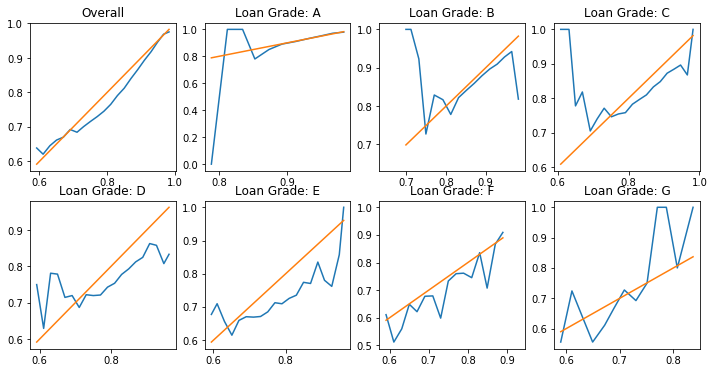

In [21]:
graph_by_grade(test.pred2, test.grade, test.target)

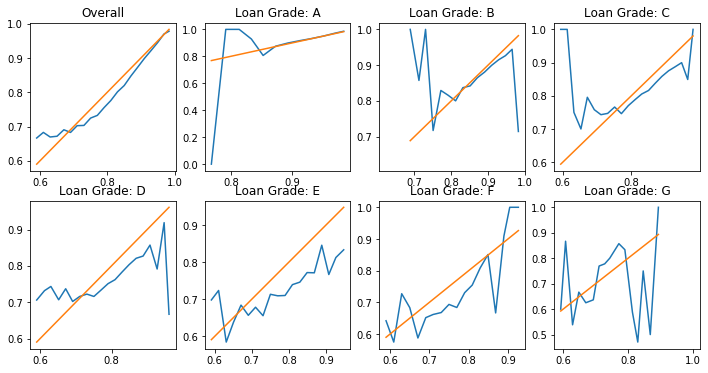

In [22]:
graph_by_grade(test['pred3'], test['grade'], test['target'])

In [25]:
test['pct_return'] = (test.total_pymnt - test.funded_amnt) / test.funded_amnt
   
def returns_by_grade(metric, grade, returns, thresh = [80, 90, 95]):
    for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
        
        cutoffs = [np.percentile(metric[grade == letter], q=x) for x in thresh]
        
        print('--------------  ' + letter + '  --------------')
        print('')
    
        print('Naive Returns:             {}%'.format(round(returns[grade==letter].mean()*100, 2)))
        print('')
        
        for c in range(len(thresh)):
            print('{} Percent Cutoff:         {}%'.format(thresh[c], round(returns[(grade == letter) & (metric >= cutoffs[c])].mean()*100,2)))
            
        print('')
        
returns_by_grade(test.pred, test.grade, test.pct_return)

--------------  A  --------------

Naive Returns:             7.14%

80 Percent Cutoff:         7.26%
90 Percent Cutoff:         7.18%
95 Percent Cutoff:         7.08%

--------------  B  --------------

Naive Returns:             8.72%

80 Percent Cutoff:         9.36%
90 Percent Cutoff:         9.32%
95 Percent Cutoff:         9.09%

--------------  C  --------------

Naive Returns:             8.3%

80 Percent Cutoff:         9.8%
90 Percent Cutoff:         10.15%
95 Percent Cutoff:         10.26%

--------------  D  --------------

Naive Returns:             7.92%

80 Percent Cutoff:         10.19%
90 Percent Cutoff:         10.55%
95 Percent Cutoff:         11.28%

--------------  E  --------------

Naive Returns:             7.29%

80 Percent Cutoff:         9.43%
90 Percent Cutoff:         10.2%
95 Percent Cutoff:         11.4%

--------------  F  --------------

Naive Returns:             9.54%

80 Percent Cutoff:         14.55%
90 Percent Cutoff:         15.42%
95 Percent Cuto

In [26]:
returns_by_grade(test.pred2, test.grade, test.pct_return)

--------------  A  --------------

Naive Returns:             7.14%

80 Percent Cutoff:         7.31%
90 Percent Cutoff:         7.19%
95 Percent Cutoff:         7.16%

--------------  B  --------------

Naive Returns:             8.72%

80 Percent Cutoff:         8.99%
90 Percent Cutoff:         9.08%
95 Percent Cutoff:         9.05%

--------------  C  --------------

Naive Returns:             8.3%

80 Percent Cutoff:         10.13%
90 Percent Cutoff:         10.32%
95 Percent Cutoff:         10.4%

--------------  D  --------------

Naive Returns:             7.92%

80 Percent Cutoff:         10.71%
90 Percent Cutoff:         11.17%
95 Percent Cutoff:         12.08%

--------------  E  --------------

Naive Returns:             7.29%

80 Percent Cutoff:         10.11%
90 Percent Cutoff:         10.95%
95 Percent Cutoff:         11.24%

--------------  F  --------------

Naive Returns:             9.54%

80 Percent Cutoff:         14.95%
90 Percent Cutoff:         16.07%
95 Percent 

In [27]:
returns_by_grade(test.pred3, test.grade, test.pct_return)

--------------  A  --------------

Naive Returns:             7.14%

80 Percent Cutoff:         7.03%
90 Percent Cutoff:         6.99%
95 Percent Cutoff:         6.93%

--------------  B  --------------

Naive Returns:             8.72%

80 Percent Cutoff:         9.01%
90 Percent Cutoff:         9.29%
95 Percent Cutoff:         9.22%

--------------  C  --------------

Naive Returns:             8.3%

80 Percent Cutoff:         10.2%
90 Percent Cutoff:         10.51%
95 Percent Cutoff:         10.57%

--------------  D  --------------

Naive Returns:             7.92%

80 Percent Cutoff:         10.88%
90 Percent Cutoff:         11.23%
95 Percent Cutoff:         12.15%

--------------  E  --------------

Naive Returns:             7.29%

80 Percent Cutoff:         10.03%
90 Percent Cutoff:         11.12%
95 Percent Cutoff:         11.6%

--------------  F  --------------

Naive Returns:             9.54%

80 Percent Cutoff:         15.06%
90 Percent Cutoff:         18.55%
95 Percent C

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(test.target, test.pred)

0.643577633850273

In [35]:
roc_auc_score(test.target, test.pred2)

0.6712204418108337

In [36]:
roc_auc_score(test.target, test.pred3)

0.6721906298640523

Almost every model outperformed random selection by subclass. In most cases, restricting selection to a more narrow percentile increased our profitability.

The one exception is our third model on G-rated loans. Our training sample consists of 66 G-rated loans, and this is separated into 5 subclasses. Our estimate of the marginal fixed effect varies widely, and not in a linear manner as one would expect. It is fairly obviously an overfit model in this area of our sample, and thus, not surprising that our model did not perform well when selecting assets in this area.

Two things to expand on:

1. We should invest based on expected value, not necessarily odds of fully paying
    
2. We should see whether training models separately by class increases our predictive power

In [ ]:
defaults = train[train.loan_status == 'Charged Off']
defaults.head()

In [ ]:
defaults['percent_paid'] = defaults['total_pymnt'] / defaults['funded_amnt']
defaults['months_paid'] = defaults['total_pymnt'] / defaults['installment']

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Percent of Loan Paid Back')
sns.distplot(defaults.percent_paid, kde=False)

plt.subplot(1,2,2)
plt.title('Monthly installments paid back')
sns.distplot(defaults.months_paid, kde=False)

plt.show()

In [ ]:
np.mean(defaults.percent_paid)

In [ ]:
np.mean(defaults.months_paid)

The average amount paid back on loans that defaulted was about 63% of the borrowed amount,or about 18 months' worth of payments. The distributions are relatively normal-looking. Next, we need to find out if this is correlated with any of our factors, so that we can decide how we are going to get a more accurate estimate of the EV of a loan.

In [ ]:
defaults[['months_paid', 'ln_annual_inc', 'dti', 'fico_range_high', 'grade', 'sub_grade']].corr()

In [ ]:
defaults.groupby(['grade']).mean()[['months_paid', 'percent_paid']]

In [ ]:
defaults.groupby(['purpose']).mean()[['months_paid', 'percent_paid']]

In [39]:
def total_int_paid(n, i):
    ii = i/12
    return n*(ii * (1 + ii) ** n) / ((1+ii)**n - 1)-1

total_int_paid(36, .12)

test['total_int_paid'] = test.apply(lambda x: total_int_paid(36, x['int_rate']/100), axis=1)


In [40]:
test['naive_ev_m1'] = test['pred'] * test['total_int_paid'] - (1-test['pred']) * .37
test['naive_ev_m2'] = test['pred2'] * test['total_int_paid'] - (1-test['pred2']) * .37
test['naive_ev_m3'] = test['pred3'] * test['total_int_paid'] - (1-test['pred3']) * .37



In [42]:
for letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    thresh_m1_80 = np.percentile(test[test.grade == letter]['naive_ev_m1'], q=80)
    thresh_m2_80 = np.percentile(test[test.grade == letter]['naive_ev_m2'], q=80)
    thresh_m3_80 = np.percentile(test[test.grade == letter]['naive_ev_m3'], q=80)

    thresh_m1_90 = np.percentile(test[test.grade == letter]['naive_ev_m1'], q=90)
    thresh_m2_90 = np.percentile(test[test.grade == letter]['naive_ev_m2'], q=90)
    thresh_m3_90 = np.percentile(test[test.grade == letter]['naive_ev_m3'], q=90)

    thresh_m1_95 = np.percentile(test[test.grade == letter]['naive_ev_m1'], q=95)
    thresh_m2_95 = np.percentile(test[test.grade == letter]['naive_ev_m2'], q=95)
    thresh_m3_95 = np.percentile(test[test.grade == letter]['naive_ev_m3'], q=95)
    
    thresh_m1_99 = np.percentile(test[test.grade == letter]['naive_ev_m1'], q=99)
    thresh_m2_99 = np.percentile(test[test.grade == letter]['naive_ev_m2'], q=99)
    thresh_m3_99 = np.percentile(test[test.grade == letter]['naive_ev_m3'], q=99)

    print('-----------------  ' + letter + '  -----------------')
    print('')
    
    print('Naive Returns:       {}'.format(test[test.grade==letter]['pct_return'].mean()*100))
    
    print('')
    print('Model 1:')
    print('>80th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m1 >= thresh_m1_80)]['pct_return'].mean()*100))
    print('>90th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m1 >= thresh_m1_90)]['pct_return'].mean()*100))
    print('>95th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m1 >= thresh_m1_95)]['pct_return'].mean()*100))
    print('>99th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m1 >= thresh_m1_99)]['pct_return'].mean()*100))
    print('')
    
    print('Model 2:')
    print('>80th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m2 >= thresh_m2_80)]['pct_return'].mean()*100))
    print('>90th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m2 >= thresh_m2_90)]['pct_return'].mean()*100))
    print('>95th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m2 >= thresh_m2_95)]['pct_return'].mean()*100))
    print('>99th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m2 >= thresh_m2_99)]['pct_return'].mean()*100))
    print('')
    
    print('Model 3:')
    print('>80th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m3 >= thresh_m3_80)]['pct_return'].mean()*100))
    print('>90th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m3 >= thresh_m3_90)]['pct_return'].mean()*100))
    print('>95th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m3 >= thresh_m3_95)]['pct_return'].mean()*100))
    print('>99th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m3 >= thresh_m3_99)]['pct_return'].mean()*100))

    print('\n')

-----------------  A  -----------------

Naive Returns:       7.141438714524952

Model 1:
>80th percentile:    7.89136792139957
>90th percentile:    8.076954002836393
>95th percentile:    8.465941166350586
>99th percentile:    8.747345590930209

Model 2:
>80th percentile:    8.012574576308133
>90th percentile:    8.358390146277753
>95th percentile:    8.747303905733679
>99th percentile:    8.958812624912829

Model 3:
>80th percentile:    8.029043082931112
>90th percentile:    8.370702897730704
>95th percentile:    8.780136247209265
>99th percentile:    8.953085402613937


-----------------  B  -----------------

Naive Returns:       8.71693709483582

Model 1:
>80th percentile:    10.327449012272268
>90th percentile:    10.815273550718608
>95th percentile:    11.062911856580428
>99th percentile:    11.78829348542587

Model 2:
>80th percentile:    10.531867781668494
>90th percentile:    10.95075425721385
>95th percentile:    11.45608587499968
>99th percentile:    12.480797304444243

Mode

In [ ]:
returns_by_grade(test['naive_ev_m2'], test['grade'], test['pct_return'], [80, 90, 95, 99])